# Setup

Install required dependencies:

In [1]:
!pip install pytesseract
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

  Created wheel for pytesseract: filename=pytesseract-0.3.4-py2.py3-none-any.whl size=13431 sha256=8ce9184b98d119c19f8aea4e9a8d03f0c9e55b91c22e24e78bf7853593f15497
  Stored in directory: /root/.cache/pip/wheels/63/2a/a0/7596d2e0a73cf0aeffd6f6170862c4e73f3763b7827e48691a
Successfully built pytesseract
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 29 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http:/

Import required packages:

In [0]:
import sklearn
import pandas as pd
import numpy as np
import io
import os
import zipfile
import csv
import pytesseract
import re
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from PIL import Image
import fastai
from fastai import *
from fastai.text import * 
from functools import partial

# Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, drive
from oauth2client.client import GoogleCredentials
from google.colab import drive

Authenticate to Google Drive to access dataset folder:

In [0]:
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# GoogleDrive(gauth)
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## General hyper-parameters and settings:

In [0]:
#Read Image and extract text
dataset_path = "/content/drive/My Drive/document-classification/datasets/rvl-cdip/mini-dataset-1488-288-192"
cnn_dataset_unzip_path = "/content/drive/My Drive/document-classification/datasets/rvl-cdip"
file_to_unzip = "mini-dataset-1488-288-192.zip"
models_folder_path = "/content/drive/My Drive/document-classification/models/text-classificator"

path_train = os.path.join(dataset_path, 'train_extracted.csv')
path_test = os.path.join(dataset_path, 'test_extracted.csv')
path_valid = os.path.join(dataset_path, 'valid_extracted.csv')

unzip = False
# Generate textual dataset
generate_dataset = False

Check if GPU is available:

In [0]:
# Non disponibile per FastAI?
# from tensorflow.python.client import device_lib 
# display(device_lib.list_local_devices())
# assert tf.config.list_physical_devices('GPU')

# Textual dataset generation


## Unzip original dataset


In [0]:
def unzip_dataset(path,file_to_unzip):
    with zipfile.ZipFile(os.path.join(path, file_to_unzip), 'r') as zip_file:
        zip_file.extractall(path)
        print("unzipped")

# run one times only
if unzip:
  unzip_dataset(cnn_dataset_unzip_path, file_to_unzip)

## Functions

> ocr_core(filename): extract the text from an image with pytesseract


> preprocess_text(text): take a string and prepare it for our structure

> generate_dataset_for_UlmFit(original_csv, extracted_csv, path): reads the images and the labels in _original_csv_ and creates a csv dataset file with the textual information extracted from those images



In [0]:
def ocr_core(filename):
    """
    This function will handle the core OCR processing of images.
    """
    text = pytesseract.image_to_string(Image.open(filename))  # We'll use Pillow's Image class to open the image and pytesseract to detect the string in the image
    return text

#works
print(ocr_core("/content/drive/My Drive/document-classification/datasets/rvl-cdip/mini-dataset-1488-288-192/test/0/0/0/0/2078319705.tif"))

2078319705

From: Temple, Richmond on Tue, Aug 13, 1996 2:20 Pu
Subject: Fa: Milw. Business Journ.
To: McCormick, Brendan


In [0]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):

  replaced_text = re.sub('[^a-zA-Z0-9 \n\.]', ' ', text)
  #Now, we will get rid of the stopwords from our text data. If you have never used stopwords before, then you will have to download them from the nltk package as I’ve shown below:
  # de-tokenization 
  text_tokens = word_tokenize(replaced_text)
  #print(text_tokens)
  tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]

  output = ' '.join(tokens_without_sw)

  return output.lower()

text = 'From: Temple, Richmond on Tue, Aug 13, 1996 2:20 Pu \nSubject: Fa: Milw. Business Journ. \nTo: McCormick, Brendan!!!!'
result = preprocess_text(text)
print(result)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
from temple richmond tue aug 13 1996 2 20 pu subject fa milw . business journ . to mccormick brendan


In [0]:
#I have 3 csv file: test-labels.csv, train-labels.csv, valid-labels.csv
def generate_dataset_for_UlmFit(original_csv, extracted_csv, path):
    origin = os.path.join(path, original_csv)
    with open(origin, 'r') as f:
        relative_paths = list(csv.reader(f, delimiter=','))
        
        output = []
        #count = 0
        for relative_path in tqdm(relative_paths):
            #if count == 1:
            #  break
            #count+=1
            #print(relative_path[0])
            img_for_ocr = os.path.join(path, relative_path[0])
            text = ocr_core(img_for_ocr)
            processed_text = preprocess_text(text)
            if not processed_text:
              processed_text ='~'
            label = relative_path[1]
            output.append([processed_text, label])
        #print(output)

        output_path = os.path.join(path, extracted_csv)
        with open(output_path, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerows(output)

## Dataset generation
Set up the path of our file in Google Drive and generate the csv file for our text classification (required one time only)

In [0]:
#run one time once (lot of times)
path_train = os.path.join(dataset_path, 'train_extracted.csv')
path_test = os.path.join(dataset_path, 'test_extracted.csv')
path_valid = os.path.join(dataset_path, 'valid_extracted.csv')

if generate_dataset:
    nltk.download('stopwords')
    nltk.download('punkt')
    generate_dataset_for_UlmFit('test-labels.csv', 'test_extracted.csv', dataset_path)
    print('Test extracted')
    generate_dataset_for_UlmFit('valid-labels-modified.csv', 'valid_extracted.csv', dataset_path)
    print('Validation extracted')
    generate_dataset_for_UlmFit('train-labels.csv', 'train_extracted.csv', dataset_path)
    print('Train extracted')


# Import dataset data preparation

> Preparing data with pandas dataframe for [fastai](https://www.fast.ai/)




In [0]:
df_trn, df_val, df_test = pd.read_csv(path_train,names=['text','label']), pd.read_csv(path_valid,names=['text','label']), pd.read_csv(path_test,names=['text','label'])
print(df_trn.shape, df_val.shape, df_test.shape)

(1488, 2) (288, 2) (192, 2)


In [0]:
df_trn.head()

,text,label
0,the tobacco institute ca venoor wame 08 conpar...,10
1,2074950097 eo hea werniin bamh bois veep soa34...,10
2,the anatomical record 210 115 123 1984 chronic...,6
3,the tobacco institute state activities contrib...,10
4,price mantis incanmonares re pray new york mew...,11


Preparing data with TextLM\<x>Bunch

In [0]:
# Il field path vuoto non mi piace, ma nel tutorial lo usa così e nella documentazione
# non è chiaro cosa determini
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "",
                                  text_cols="text", label_cols="label")
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val,
                                      text_cols="text", label_cols="label", vocab=data_lm.train_ds.vocab, bs=32)


In [0]:
data_lm.show_batch()

idx,text
0,26 xxunk xxunk xxbos xxunk eo hea xxunk xxunk xxunk xxunk xxunk xxunk form xxunk 7 xxunk soe xxunk 6 20 no xxbos the anatomical record 210 115 123 1984 chronic infusion opiate peptides rat cerebrospinal fluid with osmotic minipumps lc . saland e. xxunk anv a. xxunk department anatomy the university new mexico school medicine albuquerque nm xxunk abstract beta endorphin related opiate peptides opiate xxunk xxunk naloxone chronically
1,xxunk xxunk xxunk xxunk xxunk 430 xxunk 7 8 xxunk xxunk xxunk 5 xxunk xxbos ee 5 gig aed bon . xxunk progress report 70 the food and drug administration from the national cancer institute concerning the national bladder cancer study collaborating authors principal investigator robert xxunk md dsc . study coordinator patricia xxunk xxunk ma msc . dr . xxunk j. xxunk dr . max myers dr . margaret
2,pulmonary medicine june 1990 alpha xxunk alpha american xxunk society california thoracic society national research service award 1977 nie clinical investigator award 1930 xxunk xxbos memorandum february 24 1971 to dr . f. j schultz from john r. wagner subject summary preliminary work pyrolysis pmo . a pyrolysis train set pyrolyze 100 mg samples pmo the apparatus illustrated belo ye co xxunk . 9a crushed xxunk xxunk filled pyrolysis tube
3,note xxunk visual closure . j psychol 65 153 155 1967 . chyatte d sundt tm cerebral vasospasm subarachnoid xxunk . mayo clinic proceedings 59 498 505 1984 chyatte d chyatte c pain sensitivity reduced mild xxunk xxunk . xxunk xxunk 14 2 180 182 1972 . chyatte d rusch n sundt tm prevention chronic experimental cerebral vasospasm xxunk high dose xxunk . j neurosurg 59 925 xxunk 1983 .
4,morris involvement xxunk received invited participate 1989 accepted . soul food picnic june 18 19 1988 the indiana black expo soul food picnic held two day period indianapolis washington park . our primary brand used sponsorship sampling marlboro family brands . official police xxunk estimates xxunk 110 000 people . philip morris activities included 1 . a marlboro booth 2 . marlboro signs throughout park routes leading park 3 .


In [0]:
data_clas.show_batch()

text,target
xxbos xxunk nma cree dete xxunk xxunk xxunk xxunk otter xxunk 5 to xxunk wore xxunk xxunk at sr xxunk deutsches acon xxunk xxunk tho xxunk xxunk beam mero . xxunk toa xxunk xxunk a . the nt fang wee acted toy xxunk whereas o. xxunk xxunk xxunk xxunk xxunk ate xxunk 7 xxunk . tho xxunk f.c ma ws ered eo trom . ure lang rough xxunk 0s .,6
xxbos communication 3 azido 3 deoxythymidine potently inhibits protein glycosylation xxunk mechanism for azt cytotoxicity received publication march 4 1994 revised form march 25 1994 yan paul xxunk xxunk t hall xxunk robert d. xxunk from department chemistry biochemistry university colorado boulder colorado xxunk xxunk 8 azido s deoxythymidine azt mary xxunk agents used th treatment human immunodeficiency virus hiv infection . xxunk xxunk azt therapy accompanied severe side ef,6
xxbos ee ba . es hs the law xxunk provide xxunk educational business kennedy citizen assessment sn grunt ae world future society last week . 35 xxunk the proposed citizens assess xxunk act perhaps far reaching implications especially unusual xxunk financing xxunk public inter xxunk . sen . kennedy told 2 xxunk assembled washington d.c . policy formation nut public participation like faith hope without charity . the xxunk formed,9
xxbos diss ths xxunk soci tor bb molecular bist in . 2 no ae is disruption receptor g protein coupling yeast promotes function sst2 dependent adaptation pathway received publication october 7 1992 jennifer l. xxunk christina xxunk xxunk xxunk j. xxunk from department celt biology physiology washington university schoo medicine st . lous missouri xxunk i m yeast saccharomyces cerevisiae g protein linked signal transduction pathway mediates response xxunk mating,6
xxbos s xxunk xxunk oy te xxunk xxunk xxunk 3 g subpopulations of b lymphocytes in germinal xxunk gwen xxunk . judy a. xxunk thomas . eric xxunk . joseph m. davie . charles d. xxunk . avo moon h. nahm epartment pathology . division laboratory medicine . department microbiology xxunk . washington university school medicine . st . xxunk . mo xxunk department cell xxunk anatomy . xxunk alabama,6


# Fine-Tuning the Pre-Trained Model and Making Predictions


## Language model training

In [0]:
#here i use AWD_LSTM for fine-tunig
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.7, model_dir=models_folder_path)

Find the best learning rate studying its trend (Experimental).

This function has been taken from this post: https://forums.fast.ai/t/automated-learning-rate-suggester/44199

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


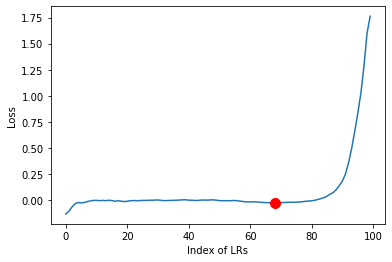

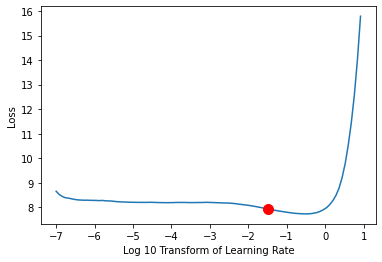

Learning rate:0.03311311214825908


In [0]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use

learning_rate = find_appropriate_lr(learn, plot=True)
print('Learning rate:' + learning_rate.__str__())

In [0]:
#learn.lr_find()

Train the learner object


In [0]:
from fastai.callbacks import EarlyStoppingCallback, SaveModelCallback

early_stopping = EarlyStoppingCallback(learn, monitor='accuracy', min_delta=0.005, patience=15, mode="max")
save_model = SaveModelCallback(learn, every="improvement", monitor="accuracy", mode="max", name="best-language-model")
learn.fit_one_cycle(50, max_lr=learning_rate, callbacks=[early_stopping, save_model])
print("Training completed")

epoch,train_loss,valid_loss,accuracy,time
0,7.727531,6.398638,0.231027,00:05
1,7.175861,6.051183,0.251719,00:05
2,6.749428,5.871381,0.258415,00:05
3,6.353461,5.744367,0.266027,00:05
4,5.963281,5.690215,0.266183,00:05
5,5.579401,5.711516,0.267946,00:05
6,5.224978,5.771670,0.264665,00:05
7,4.910710,5.882354,0.258638,00:05
8,4.665440,6.004016,0.252567,00:05
9,4.477193,6.119929,0.251763,00:05


Better model found at epoch 0 with accuracy value: 0.2310267984867096.
Better model found at epoch 1 with accuracy value: 0.25171875953674316.
Better model found at epoch 2 with accuracy value: 0.258415162563324.
Better model found at epoch 3 with accuracy value: 0.2660267949104309.
Better model found at epoch 4 with accuracy value: 0.2661830484867096.
Better model found at epoch 5 with accuracy value: 0.26794642210006714.
Epoch 19: early stopping
Training completed


Load the best model from the previous stage of training (due to early stopping it could be not the last epoch one) and save the encoder part.

In [0]:
# Load the best model from the previous stage of training
learn.load("best-language-model")
learn.save_encoder("lm-encoder")

## Text classifier training

Create the text classifier and load the encoder from the previous stage.

In [0]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.7, model_dir=models_folder_path)
learn.load_encoder('lm-encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1488 items)
x: TextList
xxbos the tobacco institute ca xxunk wame 08 xxunk name xxunk oars enter wa tate l xxunk ere xxunk i street . xxunk washington . bc xxunk pay date xxunk . fa xxunk gad li xxwrep 5 ee xxunk xxunk to the ap xxunk xxunk times order of pl rok xxunk pron tk al xxunk non xxunk xo xxunk xxunk po 200 25 hosk xxrep 4 o ion xxunk xxunk 26 xxunk xxunk,xxbos xxunk eo hea xxunk xxunk xxunk xxunk xxunk xxunk form xxunk 7 xxunk soe xxunk 6 20 no,xxbos the anatomical record 210 115 123 1984 chronic infusion opiate peptides rat cerebrospinal fluid with osmotic minipumps lc . saland e. xxunk anv a. xxunk department anatomy the university new mexico school medicine albuquerque nm xxunk abstract beta endorphin related opiate peptides opiate xxunk xxunk naloxone chronically infused periods 24 48 hours lateral cerebral ventricle adult male rats using alza osmotic minipumps . previous studies suggested chemotactic like effect opiat

Find the best learning rate using the function from above.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


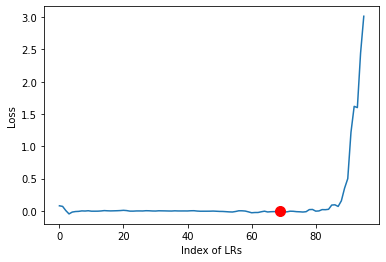

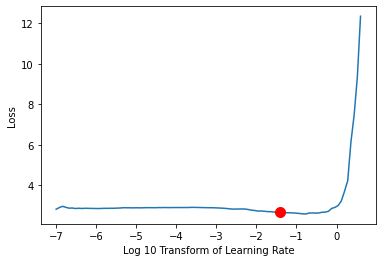

Learning rate:0.03981071705534969


In [0]:
learning_rate = find_appropriate_lr(learn, plot=True)
print('Learning rate:' + learning_rate.__str__())

Update the callbacks and train the text classifier.

In [0]:
early_stopping = EarlyStoppingCallback(learn, monitor='accuracy', min_delta=0.005, patience=15, mode="max")
save_model = SaveModelCallback(learn, every="improvement", monitor="accuracy", mode="max", name="best-text-classifier")

learn.fit_one_cycle(50, max_lr=learning_rate, callbacks=[early_stopping, save_model])
print("Training completed")

epoch,train_loss,valid_loss,accuracy,time
0,2.323604,1.971709,0.447917,00:04
1,2.129014,1.703220,0.500000,00:03
2,1.960783,1.654234,0.489583,00:04
3,1.845270,1.718544,0.493056,00:04
4,1.907176,1.721141,0.496528,00:03
5,1.867492,1.915658,0.440972,00:03
6,1.842446,1.807778,0.458333,00:04
7,1.860500,1.723427,0.503472,00:04
8,1.858767,1.682135,0.555556,00:03
9,1.838912,1.669202,0.506944,00:04


Better model found at epoch 0 with accuracy value: 0.4479166567325592.
Better model found at epoch 1 with accuracy value: 0.5.
Better model found at epoch 7 with accuracy value: 0.5034722089767456.
Better model found at epoch 8 with accuracy value: 0.5555555820465088.
Epoch 24: early stopping
Training completed


# Results
The following cells evaluate the performance and correctness of the trained model.

Load the trained model.

In [0]:
learn.load("best-text-classifier")

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1488 items)
x: TextList
xxbos the tobacco institute ca xxunk wame 08 xxunk name xxunk oars enter wa tate l xxunk ere xxunk i street . xxunk washington . bc xxunk pay date xxunk . fa xxunk gad li xxwrep 5 ee xxunk xxunk to the ap xxunk xxunk times order of pl rok xxunk pron tk al xxunk non xxunk xo xxunk xxunk po 200 25 hosk xxrep 4 o ion xxunk xxunk 26 xxunk xxunk,xxbos xxunk eo hea xxunk xxunk xxunk xxunk xxunk xxunk form xxunk 7 xxunk soe xxunk 6 20 no,xxbos the anatomical record 210 115 123 1984 chronic infusion opiate peptides rat cerebrospinal fluid with osmotic minipumps lc . saland e. xxunk anv a. xxunk department anatomy the university new mexico school medicine albuquerque nm xxunk abstract beta endorphin related opiate peptides opiate xxunk xxunk naloxone chronically infused periods 24 48 hours lateral cerebral ventricle adult male rats using alza osmotic minipumps . previous studies suggested chemotactic like effect opiat

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

# len(data.valid_ds)==len(losses)==len(idxs)

Confusion matrix:

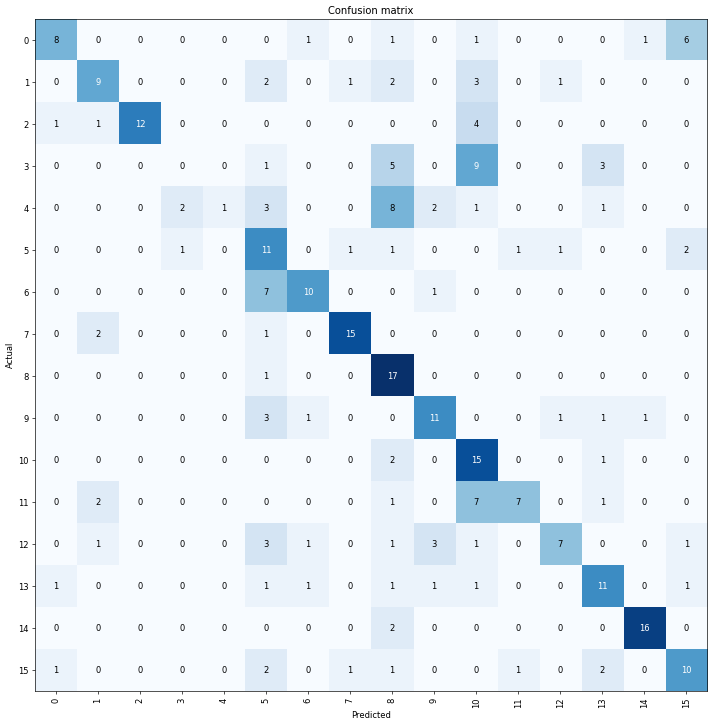

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Most confused categories:

In [0]:
interp.most_confused(min_val=2)

[(3, 10, 9),
 (4, 8, 8),
 (6, 5, 7),
 (11, 10, 7),
 (0, 15, 6),
 (3, 8, 5),
 (2, 10, 4),
 (1, 10, 3),
 (3, 13, 3),
 (4, 5, 3),
 (9, 5, 3),
 (12, 5, 3),
 (12, 9, 3),
 (1, 5, 2),
 (1, 8, 2),
 (4, 3, 2),
 (4, 9, 2),
 (5, 15, 2),
 (7, 1, 2),
 (10, 8, 2),
 (11, 1, 2),
 (14, 8, 2),
 (15, 5, 2),
 (15, 13, 2)]